# Introduction to Hidden Markov Models

## Prerequisites

* Markov Chains and Markovian Processes
* Probability and Bayes' Theorem
* Linear Algebra

## Learning Goals

* Approximate Reality: transform a basic question with possible business value into a simple supervised learning problem (w/ label noise),
* Create a baseline model to check the "fidelity" of the proxy to reality,
* Build a Hidden Markov Model using `seqlearn` and/or `hmmlearn`.

## Imports

In [1]:
# The original version of seqlearn has scipy dependencies which are out of date.
# !pip install -U git+https://github.com/PureMath86/seqlearn

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

import yfinance as yf

from scipy.signal import savgol_filter, argrelmin, argrelmax

from seqlearn.hmm import MultinomialHMM
from hmmlearn.hmm import GaussianHMM as HMM

from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score 
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from category_encoders import WOEEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import talib

import warnings
warnings.filterwarnings("ignore")

import gc; gc.enable();

/Users/frkornet/opt/anaconda3/envs/learn/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [3]:
SCORING = 'accuracy' # 'roc_auc'

## Get Stock Data

In [4]:
# asset = yf.Ticker("AGRX")
# asset = yf.Ticker("AAPL")
asset = yf.Ticker("GOOGL")

# get historical market data
hist = asset.history(period="24mo")

In [5]:
len(hist)

504

In [6]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-02-06,1033.98,1087.38,1030.01,1084.43,3831500,0,0
2018-02-07,1084.97,1086.53,1054.62,1055.41,2597100,0,0
2018-02-08,1059.87,1063.93,1004.70,1007.71,3339600,0,0
2018-02-09,1025.88,1051.72,997.00,1046.27,4918000,0,0
2018-02-12,1056.67,1065.57,1045.49,1054.56,2812000,0,0


## Visualize

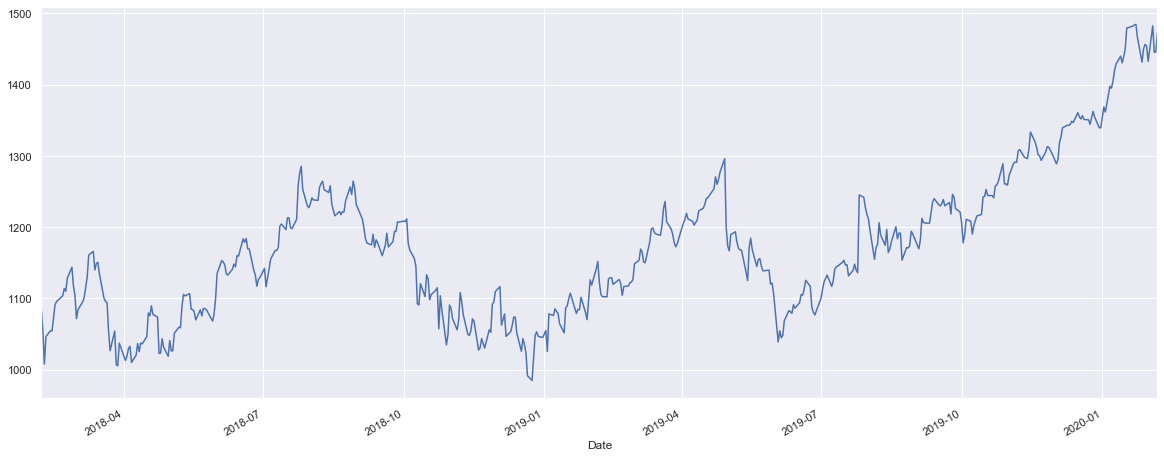

In [7]:
plt.figure(figsize=(20,8))
hist.Close.plot()
plt.show()

## Smooth

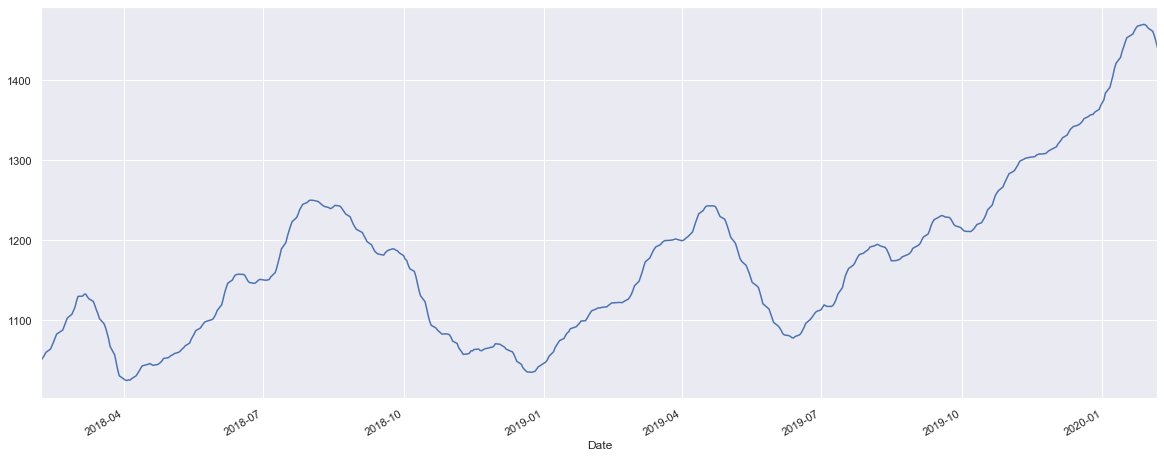

In [8]:
window = 15
hist['smooth'] = savgol_filter(hist.Close, 2*window+1, polyorder=3)
plt.figure(figsize=(20,8))
hist.smooth.plot()

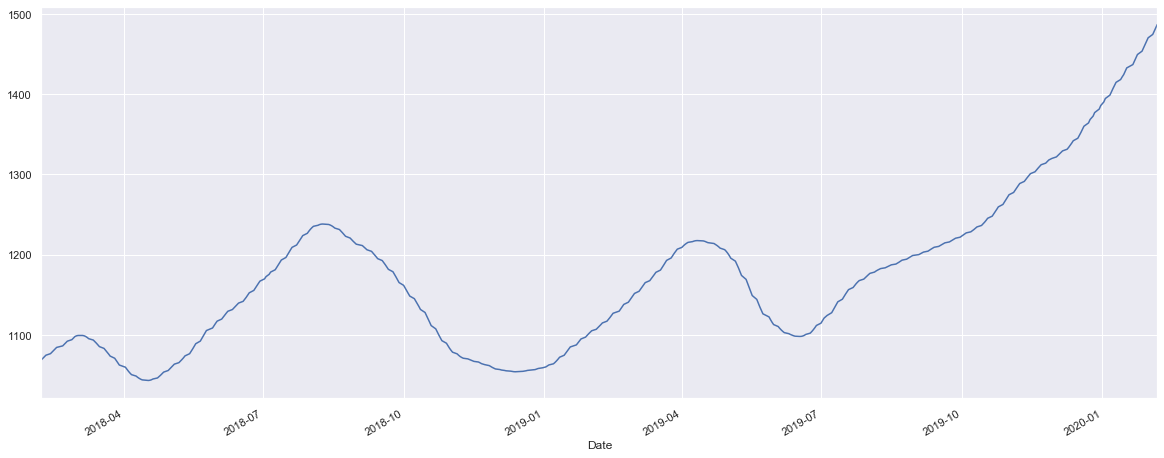

In [9]:
hist['smooth'] = savgol_filter(hist.smooth, 2*window+1, polyorder=1)
plt.figure(figsize=(20,8))
hist.smooth.plot()

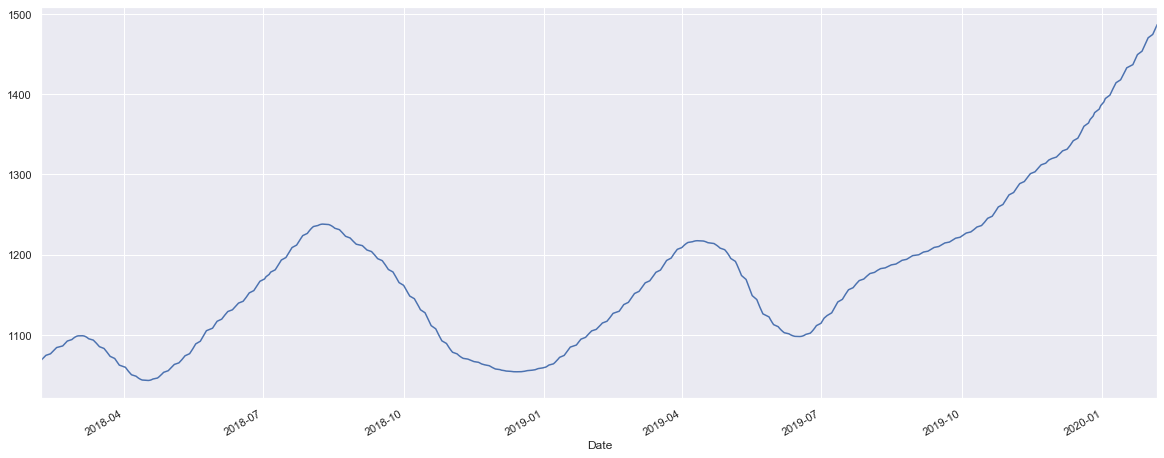

In [10]:
hist['smooth'] = savgol_filter(hist.smooth, window, polyorder=3)
plt.figure(figsize=(20,8))
hist.smooth.plot()

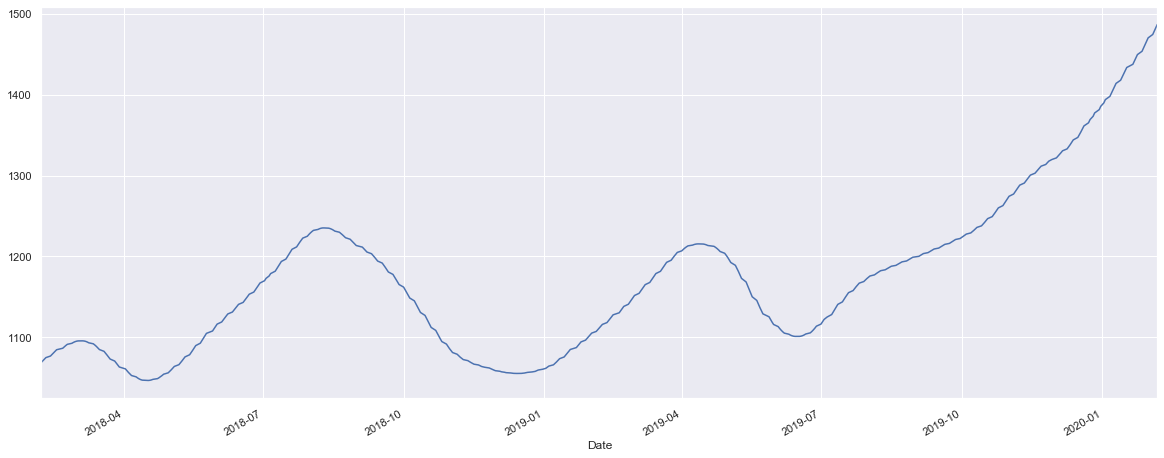

In [11]:
hist['smooth'] = savgol_filter(hist.smooth, window, polyorder=1)
plt.figure(figsize=(20,8))
hist.smooth.plot()

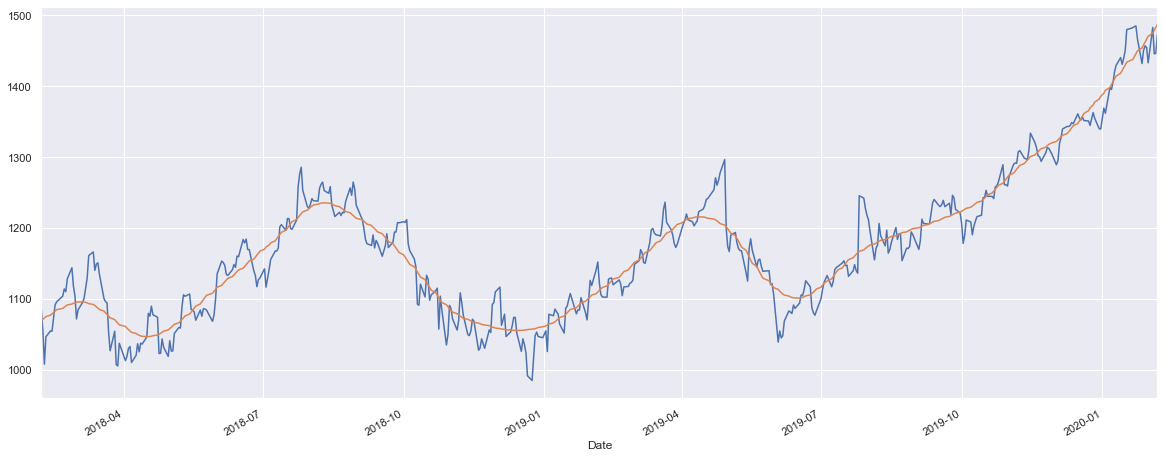

In [12]:
plt.figure(figsize=(20,8))
hist.Close.plot()
hist.smooth.plot()
plt.show()

## Create a Target : "Near" Local Minima / Breakout Points

min_ids= [48, 216, 340]
max_ids= [18, 129, 297]


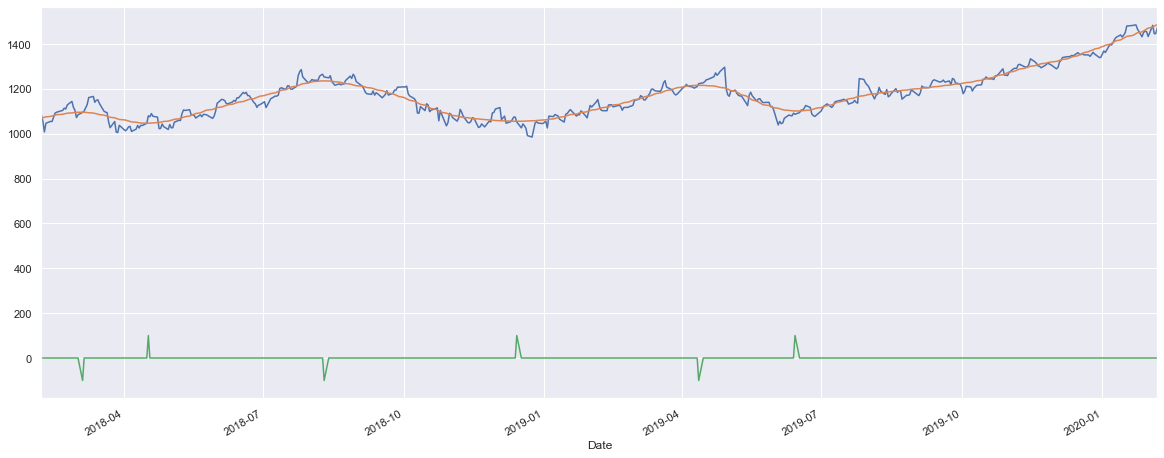

In [13]:
target = 'target'
hist[target] = 0

min_ids = argrelmin(hist.smooth.values)[0].tolist()
print("min_ids=", min_ids)
max_ids = argrelmax(hist.smooth.values)[0].tolist()
print("max_ids=", max_ids)

hist[target].iloc[min_ids] = 1
hist[target].iloc[max_ids] = -1

plt.figure(figsize=(20,8))
hist.Close.plot()
hist.smooth.plot()
(hist[target]*100).plot()
plt.show()

In [14]:
# focus only on buy signal and not on sell signal 
hist[target] = hist[target].replace(0, np.nan).interpolate(method='slinear').fillna(0)
# FRK: modified threshold to see what the impact is. Originally 0.8
# hist[target] = (hist[target] > 0.8).astype(np.int)
hist[target] = (hist[target] > 0.5).astype(np.int)

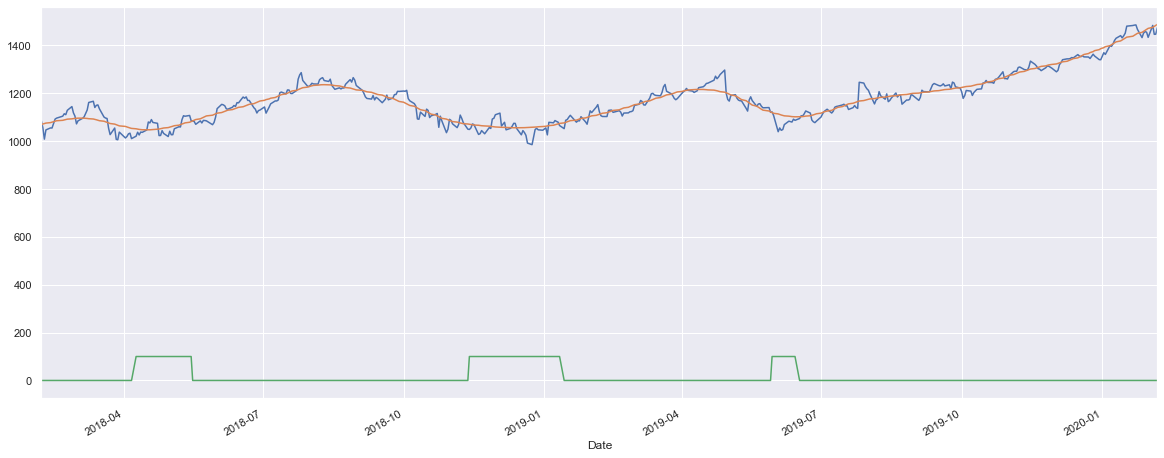

In [15]:
plt.figure(figsize=(20,8))
hist.Close.plot()
hist.smooth.plot()
(hist[target]*100).plot()
plt.show()

## Feature Engineering

In [16]:
data = hist[['Close', 'Open', 'Low', 'High']]
data.head()

,Close,Open,Low,High
Date,,,,
2018-02-06,1084.43,1033.98,1030.01,1087.38
2018-02-07,1055.41,1084.97,1054.62,1086.53
2018-02-08,1007.71,1059.87,1004.70,1063.93
2018-02-09,1046.27,1025.88,997.00,1051.72
2018-02-12,1054.56,1056.67,1045.49,1065.57


In [17]:
len(data)

504

In [18]:
windows = [3, 5, 10, 15, 20, 30, 45, 60]

for i in windows:
    ma = data.Close.rolling(i).mean()
    data['MACD_'+str(i)] = ma - data.Close
    data['PctDiff_'+str(i)] = data.Close.diff(i)
    data['StdDev_'+str(i)] = data.Close.rolling(i).std()

factor = data.Close.copy()
for c in data.columns.tolist():
    data[c] = data[c] / factor
    
data[target] = hist[target]
data = data.dropna()
del data['Close']

used_cols = [c for c in data.columns.tolist() if c not in [target]]
data.head()

,Open,Low,High,MACD_3,PctDiff_3,StdDev_3,MACD_5,PctDiff_5,StdDev_5,MACD_10,...,MACD_30,PctDiff_30,StdDev_30,MACD_45,PctDiff_45,StdDev_45,MACD_60,PctDiff_60,StdDev_60,target
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-03,0.999094,0.982062,1.004278,0.004612,0.007522,0.008200,0.002266,-0.016574,0.007975,0.011712,...,0.010593,-0.065965,0.022074,0.037194,-0.075631,0.045162,0.042570,-0.056640,0.043761,1
2018-05-04,0.970133,0.968649,1.000837,-0.015747,0.009753,0.013638,-0.017568,0.018601,0.012443,-0.014569,...,-0.013226,-0.002046,0.021509,0.012387,-0.019420,0.044129,0.017998,-0.004196,0.042759,1
2018-05-07,0.994743,0.991326,1.005229,-0.013095,0.031535,0.016263,-0.017696,0.038586,0.014000,-0.023792,...,-0.020070,0.031063,0.021590,0.003785,-0.023295,0.043685,0.010683,0.048846,0.041735,1
2018-05-08,1.005696,0.993435,1.006272,-0.002116,0.030503,0.004396,-0.013518,0.016853,0.015919,-0.019594,...,-0.019123,0.004251,0.021723,0.003851,-0.034168,0.043492,0.011708,0.011638,0.041687,1
2018-05-09,0.977180,0.975352,1.004637,-0.018320,0.034850,0.015871,-0.029469,0.057762,0.020574,-0.040871,...,-0.043959,0.075311,0.022027,-0.024381,-0.010974,0.042103,-0.015973,0.031581,0.040530,1


In [19]:
len(data)

444

In [20]:
# FRK: drop last row(s) so it splits into three without a remainder...
remainder = len(data) % 3
if remainder > 0:
   data = data[:-remainder]

In [21]:
len(data)

444

## Baseline: Scorecard

In [22]:
gc.collect()

7919

In [23]:
def stringify(data):
    data = pd.DataFrame(data)
    for c in data.columns.tolist():
        data[c] = data[c].astype(str)
    return data #.values


encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=5, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
imputer = SimpleImputer(strategy='constant', fill_value=0.0)
pca = PCA(n_components=2)
clf = LogisticRegression(class_weight='balanced', random_state=42)
# pipe = make_pipeline(pca, binner, objectify, encoder, imputer, clf)
pipe = make_pipeline(binner, objectify, encoder, imputer, clf)

X, y = data[used_cols].values, data[target].values
scores = cross_val_score(pipe, X, y, cv=5, scoring=SCORING)
scores.mean(), scores.std()

(0.7974719101123595, 0.09159371104525976)

## Transform Data

In [24]:
X = Pipeline(pipe.steps[:-1]).fit_transform(X, y) #.values

In [25]:
#print(X)

## Prep for HMM (in SeqLearn)

In [26]:
quot = 3
length = y.shape[0]
div = length//quot
remainder = length % quot
length == div*quot + remainder

True

In [27]:
print(length, div, remainder)

444 148 0


In [28]:
lengths = [div]*quot #+ [remainder]
lengths

[148, 148, 148]

## Hidden Markov Model (w/ SeqLearn)

In [29]:
hmm = MultinomialHMM(alpha=1e4)
hmm.fit(X, y, lengths)

MultinomialHMM(alpha=10000.0, decode='viterbi')

In [30]:
preds = hmm.predict(X, lengths)

In [31]:
data['pred'] = preds

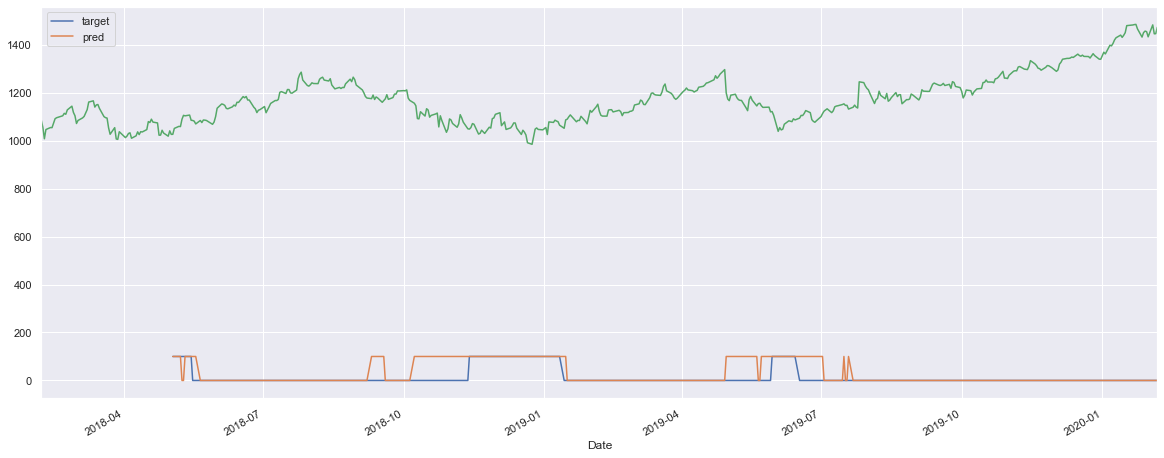

In [32]:
(data[[target, 'pred']]*100).plot(figsize=(20,8))
hist.Close.plot()
#hist.smooth.plot() # added for comparison
plt.show()

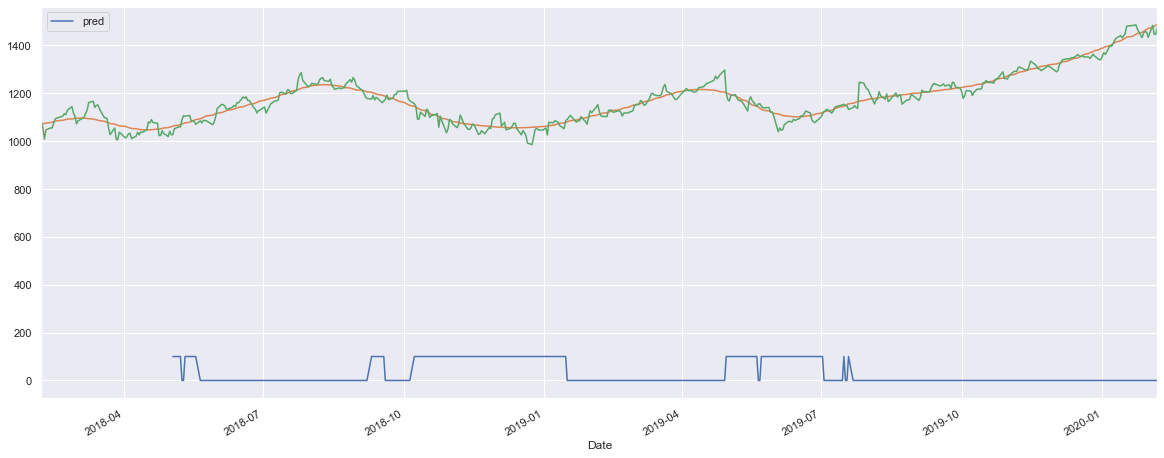

In [33]:
(data[['pred']]*100).plot(figsize=(20,8))
hist.smooth.plot()
hist.Close.plot()

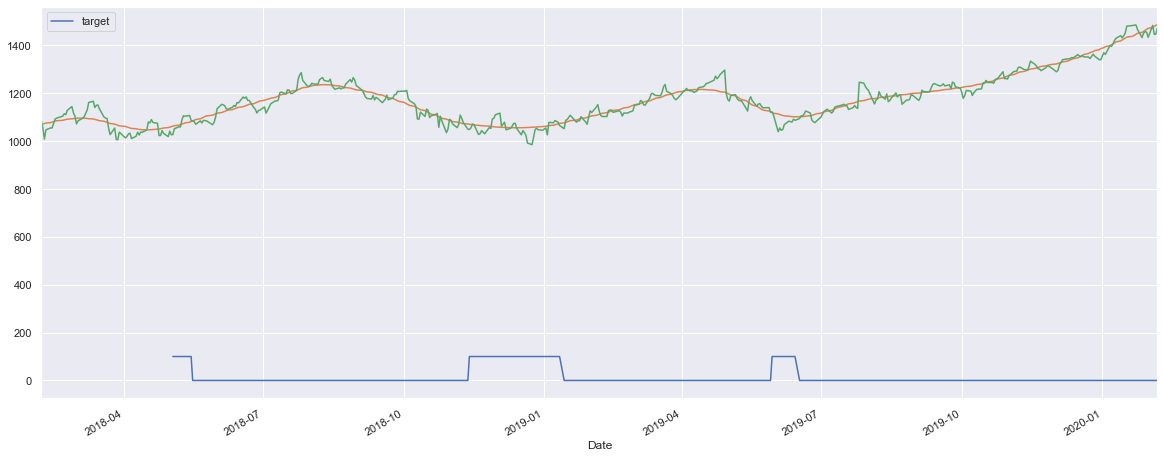

In [34]:
(data[[target]]*100).plot(figsize=(20,8))
hist.smooth.plot()
hist.Close.plot()

The predicted labels actually look better than the originally generated labels. 
Let's test the hypothesis that they are less noisy by using this new target to train the scorecard baseline again.

## Data Prep + Scorecard Fidelity Test

In [35]:
data['pred'].isna().sum()

0

In [36]:
hist[target] = data['pred'].fillna(0)
hist[target] = hist[target].fillna(0)

In [37]:
data.head()

,Open,Low,High,MACD_3,PctDiff_3,StdDev_3,MACD_5,PctDiff_5,StdDev_5,MACD_10,...,PctDiff_30,StdDev_30,MACD_45,PctDiff_45,StdDev_45,MACD_60,PctDiff_60,StdDev_60,target,pred
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-03,0.999094,0.982062,1.004278,0.004612,0.007522,0.008200,0.002266,-0.016574,0.007975,0.011712,...,-0.065965,0.022074,0.037194,-0.075631,0.045162,0.042570,-0.056640,0.043761,1,1
2018-05-04,0.970133,0.968649,1.000837,-0.015747,0.009753,0.013638,-0.017568,0.018601,0.012443,-0.014569,...,-0.002046,0.021509,0.012387,-0.019420,0.044129,0.017998,-0.004196,0.042759,1,1
2018-05-07,0.994743,0.991326,1.005229,-0.013095,0.031535,0.016263,-0.017696,0.038586,0.014000,-0.023792,...,0.031063,0.021590,0.003785,-0.023295,0.043685,0.010683,0.048846,0.041735,1,1
2018-05-08,1.005696,0.993435,1.006272,-0.002116,0.030503,0.004396,-0.013518,0.016853,0.015919,-0.019594,...,0.004251,0.021723,0.003851,-0.034168,0.043492,0.011708,0.011638,0.041687,1,1
2018-05-09,0.977180,0.975352,1.004637,-0.018320,0.034850,0.015871,-0.029469,0.057762,0.020574,-0.040871,...,0.075311,0.022027,-0.024381,-0.010974,0.042103,-0.015973,0.031581,0.040530,1,0


In [38]:
gc.collect()

data = hist[['Close', 'Open', 'Low', 'High']]
# windows = [3, 5, 10, 15, 20, 30, 45, 60]
windows = [3, 5, 10, 15, 20, 30, 45, 60]

for i in windows:
    ma = data.Close.rolling(i).mean()
    data['MACD_'+str(i)] = ma - data.Close
    data['PctDiff_'+str(i)] = data.Close.diff(i)
    data['StdDev_'+str(i)] = data.Close.rolling(i).std()

factor = data.Close.copy()
for c in data.columns.tolist():
    data[c] = data[c] / factor
    
data[target] = hist[target]
data = data.dropna()
del data['Close']

used_cols = [c for c in data.columns.tolist() if c not in [target]]
X, y = data[used_cols].values, data.target.values
scores = cross_val_score(pipe, X, y, cv=5, scoring=SCORING)
scores.mean(), scores.std()

(0.9122574055158325, 0.03708076206017005)

In [39]:
scores

array([0.94382022, 0.88764045, 0.85393258, 0.92134831, 0.95454545])

In [40]:
print(used_cols, len(used_cols))
print('')
print(X, len(X[0]))

['Open', 'Low', 'High', 'MACD_3', 'PctDiff_3', 'StdDev_3', 'MACD_5', 'PctDiff_5', 'StdDev_5', 'MACD_10', 'PctDiff_10', 'StdDev_10', 'MACD_15', 'PctDiff_15', 'StdDev_15', 'MACD_20', 'PctDiff_20', 'StdDev_20', 'MACD_30', 'PctDiff_30', 'StdDev_30', 'MACD_45', 'PctDiff_45', 'StdDev_45', 'MACD_60', 'PctDiff_60', 'StdDev_60'] 27

[[ 0.99909383  0.98206178  1.0042775  ...  0.04256959 -0.05664036
   0.04376092]
 [ 0.97013321  0.96864891  1.0008373  ...  0.01799778 -0.004196
   0.04275899]
 [ 0.9947426   0.99132577  1.00522908 ...  0.01068296  0.04884564
   0.04173482]
 ...
 [ 1.00628195  0.98382466  1.01517217 ... -0.05261679  0.1068209
   0.04278049]
 [ 1.01214343  0.98867951  1.01281422 ... -0.05143275  0.09619999
   0.04291891]
 [ 0.98579003  0.98477843  1.00585915 ... -0.06687612  0.11128311
   0.04267717]] 27


In [41]:
pipe

Pipeline(memory=None,
         steps=[('kbinsdiscretizer',
                 KBinsDiscretizer(encode='ordinal', n_bins=5,
                                  strategy='quantile')),
                ('functiontransformer',
                 FunctionTransformer(accept_sparse=False, check_inverse=False,
                                     func=<function stringify at 0x7fbb0c3918c0>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('woeencoder',
                 WOEEncoder(cols=[0, 1, 2, 3, 4, 5, 6, 7, 8...
                 SimpleImputer(add_indicator=False, copy=True, fill_value=0.0,
                               missing_values=nan, strategy='constant',
                               verbose=0)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scal

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

pipe.fit(X_train, y_train)

train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)

In [43]:
print(X_train, len(X_train[0]))

[[ 0.98519011  0.9837873   1.         ... -0.05090245  0.11721513
   0.03329597]
 [ 1.00394913  0.99918456  1.01126109 ... -0.09544693  0.15146879
   0.03846358]
 [ 1.00063737  0.9893656   1.00411232 ...  0.04265546  0.01960117
   0.03310928]
 ...
 [ 0.96931582  0.96697833  1.00124295 ...  0.032915   -0.10380491
   0.05164226]
 [ 0.98361784  0.97331266  1.00007462 ... -0.06189144  0.06742719
   0.0392293 ]
 [ 0.99034443  0.98759025  1.00127361 ... -0.04790172  0.0965318
   0.03732093]] 27


In [44]:
print("Accuracy:"); print("="*len("Accuracy:"))
print("TRAIN:", accuracy_score(y_train, train_preds))
print("TEST:", accuracy_score(y_test, test_preds))

Accuracy:
TRAIN: 1.0
TEST: 0.954954954954955


In [45]:
print("Balanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print("TRAIN:", balanced_accuracy_score(y_train, train_preds))
print("TEST:", balanced_accuracy_score(y_test, test_preds))

Balanced Accuracy:
TRAIN: 1.0
TEST: 0.9346829640947287


In [46]:
print("TRAIN:")
conf_mat = confusion_matrix(y_train, train_preds)
tn, fn, fp, tp = conf_mat.ravel()
print(conf_mat)
print('')
print("TP/(TP+FP)=", round( (tp/(tp+fp))*100, 2))

print('')

print("TEST:")
conf_mat = confusion_matrix(y_test, test_preds)
tn, fn, fp, tp = conf_mat.ravel()
print(conf_mat)
print('')
print("TP/(TP+FP)=", round( (tp/(tp+fp))*100, 2))

TRAIN:
[[237   0]
 [  0  96]]

TP/(TP+FP)= 100.0

TEST:
[[76  1]
 [ 4 30]]

TP/(TP+FP)= 88.24


In [47]:
coeffs = pipe['logisticregression'].coef_
coeffs

array([[ 0.25390944, -0.18484282,  0.13666722, -0.0821297 , -0.34616525,
         0.0566932 , -0.00600437, -0.17443486,  0.37925676, -0.50747585,
         0.45206821,  1.57719358, -0.28509507,  0.38594105,  1.38840999,
        -0.145325  ,  0.13969277,  0.72789707, -0.15079411,  0.23276215,
         0.40945181,  0.10571432,  0.79912966,  0.39393206,  1.37293094,
         0.06245597, -0.36624965]])

Frank: why does this have only two column entries? This should be 27 entries as used_cols has 27 entries... This turns out to be due to PCA as we bring it back to two 'dimensions'. I took out the PCA and now it works as expected.

In [48]:
key = [np.abs(coeffs) > 0]
key

[array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True]])]

In [49]:
print(used_cols, len(used_cols), len(key[0]))

['Open', 'Low', 'High', 'MACD_3', 'PctDiff_3', 'StdDev_3', 'MACD_5', 'PctDiff_5', 'StdDev_5', 'MACD_10', 'PctDiff_10', 'StdDev_10', 'MACD_15', 'PctDiff_15', 'StdDev_15', 'MACD_20', 'PctDiff_20', 'StdDev_20', 'MACD_30', 'PctDiff_30', 'StdDev_30', 'MACD_45', 'PctDiff_45', 'StdDev_45', 'MACD_60', 'PctDiff_60', 'StdDev_60'] 27 1


In [50]:
X_train.shape

(333, 27)

In [51]:
pd.DataFrame(pd.DataFrame(X_train, columns=used_cols).columns).iloc[key[0][0]]

,0
0,Open
1,Low
2,High
3,MACD_3
4,PctDiff_3
5,StdDev_3
6,MACD_5
7,PctDiff_5
8,StdDev_5
9,MACD_10


In [52]:
#pd.DataFrame(X.columns).iloc[key[0][0]]
a = pd.DataFrame(pd.DataFrame(X_train, columns=used_cols).columns).iloc[key[0][0]]
c = pd.DataFrame(coeffs[0]).iloc[key[0][0]]
cdf = pd.concat([a, c], axis=1)
cdf.columns = ['col', 'coeff']
cdf.sort_values(by='coeff')

,col,coeff
9,MACD_10,-0.507476
26,StdDev_60,-0.366250
4,PctDiff_3,-0.346165
12,MACD_15,-0.285095
1,Low,-0.184843
7,PctDiff_5,-0.174435
18,MACD_30,-0.150794
15,MACD_20,-0.145325
3,MACD_3,-0.082130
6,MACD_5,-0.006004


In [53]:
np.isnan(Pipeline(pipe.steps[:-1]).fit_transform(X_train, y_train)).any()

False

Frank: Unsure what is going on here and why it is showing 'nan'... There must be something wrong here... Turns out that I need to use garbage collector to free up memory as it seems to be running out of memory...

That's a much healthier looking result!

## Unsupervised HMM (w/ HMMLearn)

In [54]:
X = hist.Close.pct_change(5).dropna().values.reshape(-1,1)

hmm = HMM(n_components=4, random_state=42)
hmm.fit(X)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=4, n_iter=10, params='stmc',
            random_state=42, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
            verbose=False)

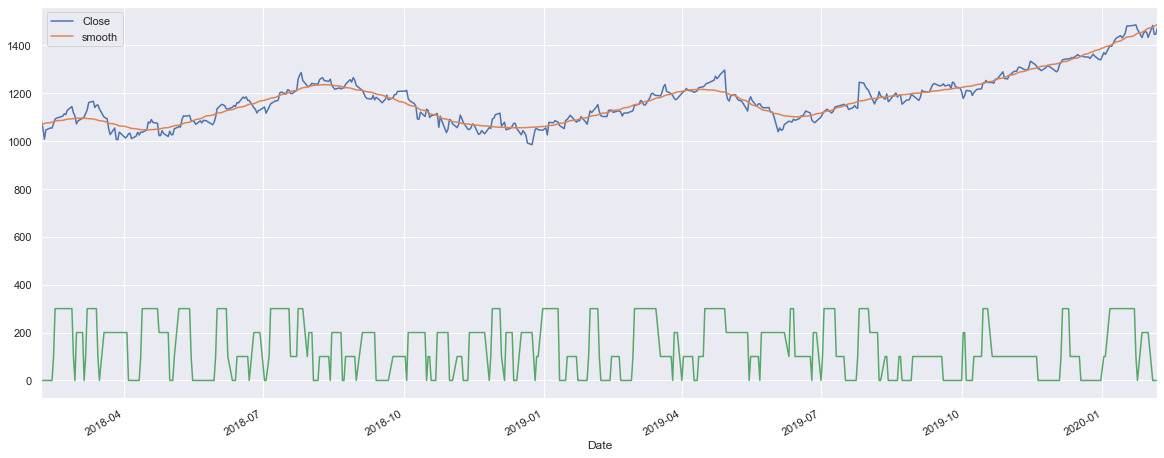

In [55]:
preds = hmm.predict(X)
preds = [0]*5 + preds.tolist()
hist['State'] = preds

# hist[['Close', 'State']].plot(figsize=(20,8))

hist[['Close', 'smooth']].plot(figsize=(20,8))
(hist['State']*100).plot()

plt.show()

In [56]:
hist.State.value_counts()

0    144
1    140
3    111
2    109
Name: State, dtype: int64

In [60]:
!ls ../data

F13_Renaissance_tech.csv F13_Renaissance_tech.txt stocks.csv


In [61]:
df=pd.read_csv('../data/F13_Renaissance_tech.txt', sep='\t')

In [62]:
df.head()

,NAME_OF_ISSUER,TITLE_OF_CLASS,CUSIP,VALUE,SHRS_OR_PRN_AMT,SH_OR_PRN,PUT_OR_CALL,DISCRETION,OTHER_MANAGER,SOLE_VOTING_AUTH,SHARED_VOTING_AUTH,NO_VOTING_AUTH
0,1347 PPTY INS HLDGS INC,COM,68244P107,443,"100,562",SH,,SOLE,0,"91,267",0,"9,295"
1,1ST CONSTITUTION BANCORP,COM,31986N102,"2,359","125,800",SH,,SOLE,0,"119,245",0,"6,555"
2,1ST SOURCE CORP,COM,336901103,"15,320","335,014",SH,,SOLE,0,"319,352",0,"15,662"
3,21VIANET GROUP INC,SPONSORED ADS A,90138A103,"8,799","1,154,767",SH,,SOLE,0,"1,119,600",0,"35,167"
4,3-D SYS CORP DEL,COM NEW,88554D205,"2,155","264,450",SH,,SOLE,0,"58,042",0,"206,408"


In [63]:
df.shape

(3394, 12)

In [64]:
df.sort_values(by='VALUE')

,NAME_OF_ISSUER,TITLE_OF_CLASS,CUSIP,VALUE,SHRS_OR_PRN_AMT,SH_OR_PRN,PUT_OR_CALL,DISCRETION,OTHER_MANAGER,SOLE_VOTING_AUTH,SHARED_VOTING_AUTH,NO_VOTING_AUTH
2312,PACIFIC DRILLING SA LUXEMBOU,COM,L7257P205,"1,000","255,700",SH,,SOLE,0,"255,700",0,0
937,DIPLOMAT PHARMACY INC,COM,25456K101,"1,004","204,900",SH,,SOLE,0,"113,152",0,"91,748"
1966,MATRIX SVC CO,COM,576853105,"1,007","58,759",SH,,SOLE,0,"4,442",0,"54,317"
2974,TECNOGLASS INC,SHS,G87264100,"1,009","124,136",SH,,SOLE,0,"71,177",0,"52,959"
1403,GSE SYS INC,COM,36227K106,"1,010","577,260",SH,,SOLE,0,"577,260",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
659,CHINA JO-JO DRUGSTORES INC,COM NEW,16949A206,991,"826,062",SH,,SOLE,0,"826,062",0,0
1703,ISHARES TR,MSCI CHINA ETF,46429B671,993,"17,700",SH,,SOLE,0,"17,700",0,0
3198,VANGUARD SCOTTSDALE FDS,MORTG-BACK SEC,92206C771,995,"18,675",SH,,SOLE,0,"18,675",0,0
2991,TENET HEALTHCARE CORP,COM NEW,88033G407,997,"45,075",SH,,SOLE,0,"2,013",0,"43,062"


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3394 entries, 0 to 3393
Data columns (total 12 columns):
NAME_OF_ISSUER        3394 non-null object
TITLE_OF_CLASS        3394 non-null object
CUSIP                 3394 non-null object
VALUE                 3394 non-null object
SHRS_OR_PRN_AMT       3394 non-null object
SH_OR_PRN             3394 non-null object
PUT_OR_CALL           3394 non-null object
DISCRETION            3394 non-null object
OTHER_MANAGER         3394 non-null int64
SOLE_VOTING_AUTH      3394 non-null object
SHARED_VOTING_AUTH    3394 non-null int64
NO_VOTING_AUTH        3394 non-null object
dtypes: int64(2), object(10)
memory usage: 318.3+ KB


In [66]:
for col in ['VALUE', 'SHRS_OR_PRN_AMT', 'SOLE_VOTING_AUTH',
            'NO_VOTING_AUTH']:
    df[col] = df[col].str.replace(',', '').astype(int)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3394 entries, 0 to 3393
Data columns (total 12 columns):
NAME_OF_ISSUER        3394 non-null object
TITLE_OF_CLASS        3394 non-null object
CUSIP                 3394 non-null object
VALUE                 3394 non-null int64
SHRS_OR_PRN_AMT       3394 non-null int64
SH_OR_PRN             3394 non-null object
PUT_OR_CALL           3394 non-null object
DISCRETION            3394 non-null object
OTHER_MANAGER         3394 non-null int64
SOLE_VOTING_AUTH      3394 non-null int64
SHARED_VOTING_AUTH    3394 non-null int64
NO_VOTING_AUTH        3394 non-null int64
dtypes: int64(6), object(6)
memory usage: 318.3+ KB


In [68]:
df.head()

,NAME_OF_ISSUER,TITLE_OF_CLASS,CUSIP,VALUE,SHRS_OR_PRN_AMT,SH_OR_PRN,PUT_OR_CALL,DISCRETION,OTHER_MANAGER,SOLE_VOTING_AUTH,SHARED_VOTING_AUTH,NO_VOTING_AUTH
0,1347 PPTY INS HLDGS INC,COM,68244P107,443,100562,SH,,SOLE,0,91267,0,9295
1,1ST CONSTITUTION BANCORP,COM,31986N102,2359,125800,SH,,SOLE,0,119245,0,6555
2,1ST SOURCE CORP,COM,336901103,15320,335014,SH,,SOLE,0,319352,0,15662
3,21VIANET GROUP INC,SPONSORED ADS A,90138A103,8799,1154767,SH,,SOLE,0,1119600,0,35167
4,3-D SYS CORP DEL,COM NEW,88554D205,2155,264450,SH,,SOLE,0,58042,0,206408


In [70]:
df.sort_values(by='VALUE', ascending=False)

,NAME_OF_ISSUER,TITLE_OF_CLASS,CUSIP,VALUE,SHRS_OR_PRN_AMT,SH_OR_PRN,PUT_OR_CALL,DISCRETION,OTHER_MANAGER,SOLE_VOTING_AUTH,SHARED_VOTING_AUTH,NO_VOTING_AUTH
467,BRISTOL MYERS SQUIBB CO,COM,110122108,1661147,32757770,SH,,SOLE,0,28224283,0,4533487
675,CHIPOTLE MEXICAN GRILL INC,COM,169656105,1609031,1914442,SH,,SOLE,0,1756732,0,157710
3224,VERISIGN INC,COM,92343E102,1562342,8282576,SH,,SOLE,0,7983085,0,299491
588,CELGENE CORP,COM,151020104,1543789,15546716,SH,,SOLE,0,15513678,0,33038
2223,NOVO-NORDISK A S,ADR,670100205,1281473,24786716,SH,,SOLE,0,24786716,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15,ABILITY INC,SHS,G8789K124,10,18160,SH,,SOLE,0,9760,0,8400
390,BENITEC BIOPHARMA LTD,SPONS ADR NEW,082053307,10,13700,SH,,SOLE,0,13700,0,0
2029,MID CON ENERGY PARTNERS LP,COM UNIT REPST,59560V109,8,20868,SH,,SOLE,0,0,0,20868
642,CHESAPEAKE GRANITE WASH TR,COM SH BEN INT,165185109,7,12189,SH,,SOLE,0,0,0,12189


In [71]:
df.TITLE_OF_CLASS.value_counts()

COM               2123
COM NEW            258
CL A               152
SHS                101
SPONSORED ADR       89
                  ... 
COM 2010             1
SBI INT-INDS         1
MSCI WORLD ETF       1
SBI INT-FINL         1
FINLS ALPHADEX       1
Name: TITLE_OF_CLASS, Length: 350, dtype: int64

In [72]:
df = df.loc[df.TITLE_OF_CLASS == 'COM']
df.shape

(2123, 12)

In [73]:
df.SH_OR_PRN.value_counts()

SH    2123
Name: SH_OR_PRN, dtype: int64

In [74]:
del df['SH_OR_PRN']

In [75]:
df.SHARED_VOTING_AUTH.value_counts()

0    2123
Name: SHARED_VOTING_AUTH, dtype: int64

In [76]:
del df['SHARED_VOTING_AUTH']

In [77]:
df.OTHER_MANAGER.value_counts()

0    2123
Name: OTHER_MANAGER, dtype: int64

In [78]:
del df['OTHER_MANAGER']

In [79]:
df.sort_values(by='VALUE', ascending=False)

,NAME_OF_ISSUER,TITLE_OF_CLASS,CUSIP,VALUE,SHRS_OR_PRN_AMT,PUT_OR_CALL,DISCRETION,SOLE_VOTING_AUTH,NO_VOTING_AUTH
467,BRISTOL MYERS SQUIBB CO,COM,110122108,1661147,32757770,,SOLE,28224283,4533487
675,CHIPOTLE MEXICAN GRILL INC,COM,169656105,1609031,1914442,,SOLE,1756732,157710
3224,VERISIGN INC,COM,92343E102,1562342,8282576,,SOLE,7983085,299491
588,CELGENE CORP,COM,151020104,1543789,15546716,,SOLE,15513678,33038
2318,PALO ALTO NETWORKS INC,COM,697435105,1192028,5848150,,SOLE,5622490,225660
...,...,...,...,...,...,...,...,...,...
2133,NAUTILUS INC,COM,63910B102,14,10400,,SOLE,10400,0
333,AZURRX BIOPHARMA INC,COM,05502L105,14,22800,,SOLE,0,22800
2390,PHIO PHARMACEUTICALS CORP,COM,71880W204,13,48677,,SOLE,48677,0
3387,ZOMEDICA PHARMACEUTICALS COR,COM,98979F107,13,36220,,SOLE,13281,22939


In [80]:
df.TITLE_OF_CLASS.value_counts()

COM    2123
Name: TITLE_OF_CLASS, dtype: int64

In [81]:
del df['TITLE_OF_CLASS']

In [82]:
df.PUT_OR_CALL.value_counts()

     2123
Name: PUT_OR_CALL, dtype: int64

In [83]:
del df['PUT_OR_CALL']

In [84]:
df.DISCRETION.value_counts()

SOLE    2123
Name: DISCRETION, dtype: int64

In [85]:
del df['DISCRETION']

In [86]:
df.sort_values(by='VALUE', ascending=False)

,NAME_OF_ISSUER,CUSIP,VALUE,SHRS_OR_PRN_AMT,SOLE_VOTING_AUTH,NO_VOTING_AUTH
467,BRISTOL MYERS SQUIBB CO,110122108,1661147,32757770,28224283,4533487
675,CHIPOTLE MEXICAN GRILL INC,169656105,1609031,1914442,1756732,157710
3224,VERISIGN INC,92343E102,1562342,8282576,7983085,299491
588,CELGENE CORP,151020104,1543789,15546716,15513678,33038
2318,PALO ALTO NETWORKS INC,697435105,1192028,5848150,5622490,225660
...,...,...,...,...,...,...
2133,NAUTILUS INC,63910B102,14,10400,10400,0
333,AZURRX BIOPHARMA INC,05502L105,14,22800,0,22800
2390,PHIO PHARMACEUTICALS CORP,71880W204,13,48677,48677,0
3387,ZOMEDICA PHARMACEUTICALS COR,98979F107,13,36220,13281,22939


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2123 entries, 0 to 3392
Data columns (total 6 columns):
NAME_OF_ISSUER      2123 non-null object
CUSIP               2123 non-null object
VALUE               2123 non-null int64
SHRS_OR_PRN_AMT     2123 non-null int64
SOLE_VOTING_AUTH    2123 non-null int64
NO_VOTING_AUTH      2123 non-null int64
dtypes: int64(4), object(2)
memory usage: 116.1+ KB


In [88]:
df = df.reset_index()
df

,index,NAME_OF_ISSUER,CUSIP,VALUE,SHRS_OR_PRN_AMT,SOLE_VOTING_AUTH,NO_VOTING_AUTH
0,0,1347 PPTY INS HLDGS INC,68244P107,443,100562,91267,9295
1,1,1ST CONSTITUTION BANCORP,31986N102,2359,125800,119245,6555
2,2,1ST SOURCE CORP,336901103,15320,335014,319352,15662
3,5,3M CO,88579Y101,17640,107300,61987,45313
4,7,A10 NETWORKS INC,002121101,15770,2272400,2226300,46100
...,...,...,...,...,...,...,...
2118,3384,ZIX CORP,98974P100,25732,3554095,3554095,0
2119,3387,ZOMEDICA PHARMACEUTICALS COR,98979F107,13,36220,13281,22939
2120,3388,ZOVIO INC,98979V102,3442,1747100,1747100,0
2121,3390,ZUMIEZ INC,989817101,1137,35900,100,35800


In [89]:
df['TICKER'] = ""

In [90]:
pd.set_option("display.max_rows", 200)

In [93]:
print(df.sample(100, random_state=42).index.to_list())

[818, 1912, 1503, 808, 1493, 585, 1705, 1775, 1229, 1169, 1273, 744, 1571, 1053, 952, 67, 1921, 1041, 1237, 1437, 289, 564, 1200, 2053, 1319, 1773, 571, 561, 321, 1910, 342, 433, 710, 888, 1847, 809, 1075, 1298, 873, 765, 1431, 111, 1428, 70, 1448, 1433, 1728, 886, 1904, 240, 1903, 892, 1247, 1449, 1975, 905, 1611, 1249, 382, 128, 2031, 422, 184, 620, 29, 298, 1540, 2058, 756, 471, 1852, 1424, 1318, 1888, 584, 1307, 51, 1549, 1882, 788, 1749, 1851, 889, 1427, 900, 410, 869, 1057, 324, 1990, 2015, 307, 1610, 281, 588, 109, 705, 1688, 1456, 581]


In [94]:
cusip_list = df.sample(100, random_state=42).index.to_list()

In [95]:
df.iloc[cusip_list]['CUSIP']

818     359523107
1912    893662106
1503    715347100
808     357023100
1493    710577107
585     249906108
1705    81577F109
1775    84763A108
1229    55262C100
1169    535219109
1273    60040X103
744     33767D105
1571    74640Y106
1053    46187W107
952     43300A203
67      013872106
1921    896945201
1041    460690100
1237    58506Q109
1437    68633D103
289     05591B109
564     12662P108
1200    55608B105
2053    946760105
1319    635017106
1773    847215100
571     237194105
561     232109108
321     12008R107
1910    893529107
342     134429109
433     G21082105
710     302081104
888     393222104
1847    871851101
809     358010106
1075    47580P103
1298    55345K103
873     384109104
765     335834107
1431    68571X103
111     030506109
1428    68404L102
70      015351109
1448    690732102
1433    68621T102
1728    825704109
886     391416104
1904    89214A102
240     06424J103
1903    89214P109
892     399473107
1247    589433101
1449    693718108
1975    91388P105
905     41

In [96]:
df.iloc[818]

index                        1276
NAME_OF_ISSUER      FUEL TECH INC
CUSIP                   359523107
VALUE                        1118
SHRS_OR_PRN_AMT           1133251
SOLE_VOTING_AUTH          1108926
NO_VOTING_AUTH              24325
TICKER                           
Name: 818, dtype: object

In [97]:
df['TICKER'].iloc[818] = 'FTEK'

In [98]:
df.iloc[1912]

index                                 3048
NAME_OF_ISSUER      TRANSGLOBE ENERGY CORP
CUSIP                            893662106
VALUE                                 4082
SHRS_OR_PRN_AMT                    3069467
SOLE_VOTING_AUTH                   2943831
NO_VOTING_AUTH                      125636
TICKER                                    
Name: 1912, dtype: object

In [99]:
df['TICKER'].iloc[1912] = 'TGA'

In [100]:
df.iloc[1503]

index                        2376
NAME_OF_ISSUER      PERSPECTA INC
CUSIP                   715347100
VALUE                       23072
SHRS_OR_PRN_AMT            883300
SOLE_VOTING_AUTH           499658
NO_VOTING_AUTH             383642
TICKER                           
Name: 1503, dtype: object

In [101]:
df['TICKER'].iloc[1503] = 'PRSP'

In [103]:
df.to_csv('../data/F13_Renaissance_tech.csv')

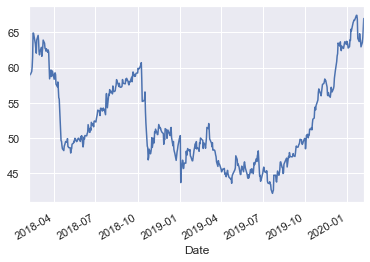

In [104]:
asset = yf.Ticker("BMY")
hist = asset.history(period="24mo")
hist.Close.plot()

## Further Reading / References

* https://en.wikipedia.org/wiki/Markov_model

* https://en.wikipedia.org/wiki/Hidden_Markov_model

### Time Series Related References

* Cross-Validation for Time-Series: https://robjhyndman.com/hyndsight/tscv/

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

* http://www.zhengwenjie.net/tscv/

* https://alan-turing-institute.github.io/sktime/

### Implementations

* SeqLearn: http://larsmans.github.io/seqlearn/index.html

* HMMLearn: https://hmmlearn.readthedocs.io/en/latest/tutorial.html
